# Sprint Challenge
## *Data Science Sprint 13*

After a sprint of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). The data is sampled for you to something more manageable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. 

## Challenge Objectives
Successfully complete all these objectives to earn full credit. 

**Successful completion is defined as passing all the unit tests in each objective.**  

There are 8 total possible points in this sprint challenge. 


There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on Yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

____

# Before you submit your notebook you must first

1) Restart your notebook's Kernel

2) Run all cells sequentially, from top to bottom, so that cell numbers are sequential numbers (i.e. 1,2,3,4,5...)
- Easiest way to do this is to click on the **Cell** tab at the top of your notebook and select **Run All** from the drop down menu. 

3) **Comment out the cell that generates a pyLDAvis visual in objective 4 (see instructions in that section).** 
____

### Part 0: Import Necessary Packages
For this section, you will need to import:
- `spacy` 
- `Pandas`
- `Seaborn`
- `Matplotlib`
- `NearestNeighbors`
- `Pipeline` 
- `TfidfVectorizer`
- `KneighborsClassifier`
- `GridSearchCV`
- `corpora`
- `LdaModel`
- `gensim`
- `re`

> **Note: This assignment is optimized to work with these specific packages. You can use import different packages, but note that this may affect how CodeGrade works, and may cause CodeGrade to fail.**

In [28]:
!pip install pyLDAvis

import spacy
spacy.util.fix_random_seed(0)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import NearestNeighbors

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import CoherenceModel, LdaModel
from gensim import models
from gensim.corpora import Dictionary


import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Visible Testing
assert pd.__package__ == 'pandas'




### Part 0: Import Data

In [3]:
# Load reviews from URL
data_url = 'https://raw.githubusercontent.com/bloominstituteoftechnology/data-science-practice-datasets/main/unit_4/unit1_nlp/review_sample.json'

# Import data into a DataFrame named df
# YOUR CODE HERE
df = pd.read_json(data_url, lines=True)


In [4]:
# Visible Testing
assert isinstance(df, pd.DataFrame), 'df is not a DataFrame. Did you import the data into df?'
assert df.shape[0] == 10000, 'DataFrame df has the wrong number of rows.'

In [5]:
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- Accept one document at a time
- Return a list of tokens

You are free to use any method you have learned this week.

**TO PASS CODEGRADE RUNTIME:**
- Do not run your tokenize function more than one time in your notebook! It is not needed until Part 4!

In [6]:
# Optional: Consider using spaCy in your function. The spaCy library can be imported by running this cell.
# A pre-trained model (en_core_web_sm) has been made available to you in the CodeGrade container.
# If you DON'T need use the en_core_web_sm model, you can comment it out below.

nlp = spacy.load('en_core_web_sm')

In [7]:
def tokenize(doc):
  doc = nlp(doc)
  tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_space]
  return tokens

In [8]:
'''Testing'''
assert isinstance(tokenize(df.sample(n=1)["text"].iloc[0]), list), "Make sure your tokenizer function accepts a single document and returns a list of tokens!"

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews (i.e. create a doc-term matrix).
    * Name that doc-term matrix `dtm`

In [9]:
%%time
# YOUR CODE HERE
vect = CountVectorizer()
dtm = vect.fit_transform(df['text'])


CPU times: user 891 ms, sys: 8.13 ms, total: 899 ms
Wall time: 915 ms



2. Write a fake review. Assign the text of the review to an object called `fake_review`. 
3. Query the fake review for the 10 most similar reviews, print the text of the reviews. 
    - Given the size of the dataset, use `NearestNeighbors` model for this. Name the model `nn`.

In [10]:
# Create and fit a NearestNeighbors model named "nn"

nn = NearestNeighbors(n_neighbors=10, algorithm='kd_tree')
nn.fit(dtm)


NearestNeighbors(algorithm='kd_tree', n_neighbors=10)

In [11]:
'''Testing.'''
assert nn.__module__ == 'sklearn.neighbors._unsupervised', ' nn is not a NearestNeighbors instance.'
assert nn.n_neighbors == 10, 'nn has the wrong value for n_neighbors'

In [12]:
# Create a fake review and find the 10 most similar reviews

# YOUR CODE HERE
fake_review = "I've been thinking about their mac and cheese for days now. I might need to check into rehab for my addiction, but it's totally worth it. I would sell my soul for another bite."
fake_review = fake_review.lower()
fake_review_dtm = vect.transform([fake_review])

In [13]:
# Visible Testing
assert isinstance(fake_review, str), "Did you write a review in the correct data type?"

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a pipeline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier.
    - Use that pipeline to train a model to predict the `stars` feature (i.e. the labels). 
    - Use that pipeline to predict a star rating for your fake review from Part 2. 



2. Create a parameter dict including `one parameter for the vectorizer` and `one parameter for the model`. 
    - Include 2 possible values for each parameter
        - **Keep the values for each parameter low. Extreme values will compromise runtime**
    - **Use `n_jobs` = 1** 
    - Due to limited computational resources on CodeGrader `DO NOT INCLUDE ADDITIONAL PARAMETERS OR VALUES PLEASE.`
    
    
3. Train the entire pipeline with a GridSearch
    - Name your GridSearch object as `gs`

In [14]:
# Find the 10 most similar reviews to the fake review
distances, indices = nn.kneighbors(fake_review_dtm)

# Print the text of the 10 most similar reviews
for index in indices:
    print(df['text'][index])

3543                                      $25 for 2 weeks
7553             Super long line but definitely worth it!
7879    Great place for breakfast had my favorite eggs...
2848    It's fine but they're snobs. Libretto is bette...
8364    Is Krung Siam Thai for slow service and food p...
3693          I love YC's! Its really good for the price.
9095    Chipotle meets Pita Jungle... this place is gr...
5883    Just like NY! I'm in Summerlin and will drive ...
5129                               Best place everrrrr!!!
4731    I'm super picky when it comes to my acrylics b...
Name: text, dtype: object


In [15]:
# Split the data into training and testing sets
train_text, test_text, train_stars, test_stars = train_test_split(df['text'], df['stars'], test_size=0.2, random_state=42)

# Create a pipeline object with a CountVectorizer and LinearSVC classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LinearSVC())
])

# Define the parameter grid for GridSearchCV
parameters = {
    'vect__max_df': (0.5, 0.75),
    'vect__min_df': (2, 3),
    'clf__C': (0.1, 1)
}

# Train the entire pipeline with a GridSearch
gs = GridSearchCV(pipeline, parameters, cv=2, n_jobs=1, verbose=2)
gs.fit(train_text, train_stars)

# Print the best score and parameters
print("Best score: %0.3f" % gs.best_score_)
print("Best parameters set:")
best_parameters = gs.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

# Predict the star rating for the fake review
fake_review_stars = gs.predict([fake_review])
print("Predicted star rating for fake review:", fake_review_stars[0])

# Test the model on the test set
test_predictions = gs.predict(test_text)
test_accuracy = accuracy_score(test_stars, test_predictions)
print("Test accuracy:", test_accuracy)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END .......clf__C=0.1, vect__max_df=0.5, vect__min_df=2; total time=   1.1s
[CV] END .......clf__C=0.1, vect__max_df=0.5, vect__min_df=2; total time=   1.8s
[CV] END .......clf__C=0.1, vect__max_df=0.5, vect__min_df=3; total time=   1.5s
[CV] END .......clf__C=0.1, vect__max_df=0.5, vect__min_df=3; total time=   1.0s
[CV] END ......clf__C=0.1, vect__max_df=0.75, vect__min_df=2; total time=   1.3s
[CV] END ......clf__C=0.1, vect__max_df=0.75, vect__min_df=2; total time=   1.2s
[CV] END ......clf__C=0.1, vect__max_df=0.75, vect__min_df=3; total time=   1.2s
[CV] END ......clf__C=0.1, vect__max_df=0.75, vect__min_df=3; total time=   1.1s
[CV] END .........clf__C=1, vect__max_df=0.5, vect__min_df=2; total time=   1.2s
[CV] END .........clf__C=1, vect__max_df=0.5, vect__min_df=2; total time=   1.2s
[CV] END .........clf__C=1, vect__max_df=0.5, vect__min_df=3; total time=   1.3s
[CV] END .........clf__C=1, vect__max_df=0.5, vec

In [16]:
# Visible Testing
prediction = gs.predict(["This is your prediction statement."])[0]
assert prediction in df.stars.values, 'You gs object should be able to accept raw text within a list. Did you include a vectorizer in your pipeline?'

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
    - Set num_topics to `5`
    - Name your LDA model `lda`
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

When you instantiate your LDA model, it should look like this: 

```python
lda = LdaModel(corpus=corpus,
               id2word=id2word,
               random_state=723812,
               num_topics = num_topics,
               passes=1
              )

```

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

In [26]:
data = df['text'].values.tolist()
data = [simple_preprocess(text) for text in data]

# Create the dictionary and document term matrix
id2word = Dictionary(data)
corpus = [id2word.doc2bow(text) for text in data]

# Train the LDA model on the corpus
num_topics = 5
lda = models.LdaModel(corpus=corpus,
                      id2word=id2word,
                      random_state=723812,
                      num_topics=num_topics,
                      passes=1)

In [29]:
# Print the topics and the top 3 words for each topic
for idx, topic in lda.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx+1, topic))

# Create a visualization of the topic distribution in the dataset
topic_distribution = [lda[doc] for doc in corpus]
topic_counts = [[tup[1] for tup in lst] for lst in topic_distribution]
df_topic_counts = pd.DataFrame(topic_counts)
df_topic_counts.columns = ['Topic {}'.format(i) for i in range(1, num_topics+1)]
df_topic_counts['Dominant Topic'] = np.argmax(df_topic_counts.values, axis=1)


Topic: 1 
Words: 0.046*"and" + 0.045*"the" + 0.025*"to" + 0.021*"is" + 0.018*"of" + 0.016*"you" + 0.015*"in" + 0.012*"it" + 0.011*"for" + 0.011*"this"
Topic: 2 
Words: 0.059*"the" + 0.037*"and" + 0.028*"was" + 0.021*"it" + 0.017*"of" + 0.015*"for" + 0.013*"to" + 0.013*"with" + 0.012*"we" + 0.012*"is"
Topic: 3 
Words: 0.034*"the" + 0.031*"and" + 0.024*"to" + 0.018*"we" + 0.015*"was" + 0.012*"pizza" + 0.010*"it" + 0.009*"that" + 0.009*"for" + 0.008*"had"
Topic: 4 
Words: 0.056*"the" + 0.034*"and" + 0.033*"to" + 0.018*"was" + 0.016*"it" + 0.015*"of" + 0.014*"my" + 0.013*"in" + 0.013*"that" + 0.012*"for"
Topic: 5 
Words: 0.034*"and" + 0.023*"to" + 0.021*"we" + 0.016*"our" + 0.015*"the" + 0.014*"in" + 0.014*"my" + 0.013*"for" + 0.012*"was" + 0.012*"they"


## Note about  pyLDAvis

**pyLDAvis** is the Topic modeling package that we used in class to visualize the topics that LDA generates for us.

You are welcomed to use pyLDAvis if you'd like for your visualization. However, **you MUST comment out the code that imports the package and the cell that generates the visualization before you submit your notebook to CodeGrade.** 

Although you should leave the print out of the visualization for graders to see (i.e. comment out the cell after you run it to create the viz). 

### 1. Estimate a LDA topic model of the review text

* Use the `tokenize` function you created earlier to create tokens.
* Create an `id2word` object. 
> Hint: Use `corpora.Dictionary`
* Create a `corpus` object.
> Hint: Use `id2word.doc2bow`
* Instantiate an `lda` model. 

>> Remember to read the LDA docs for more information on the various class attributes and methods available to you in the LDA model: https://radimrehurek.com/gensim/models/ldamodel.html

#### Testing

In [30]:
# Visible Testing

assert lda.get_topics().shape[0] == 5, 'Did your model complete its training? Did you set num_topics to 5?'

#### 2. Create 2 visualizations of the results:
1. Create a visualization using pyLDAvis. Run the cell, then comment out your code before submission, leaving the visualization in the cell.

2. Create a visualization using the matplotlib library and utilizing the subplots function. Assign this visualization to a variable called `visual_plot`.


In [50]:
# Cell for pyLDAvis visualization
# YOUR CODE HERE

import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

## Create the visualization
vis = gensimvis.prepare(lda, corpus, id2word)

# Display the visualization
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
ERROR:concurrent.futures:exception calling callback for <Future at 0x7f03139b9f60 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'
"""

The above exception was the direct cause of the following exc

BrokenProcessPool: ignored

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


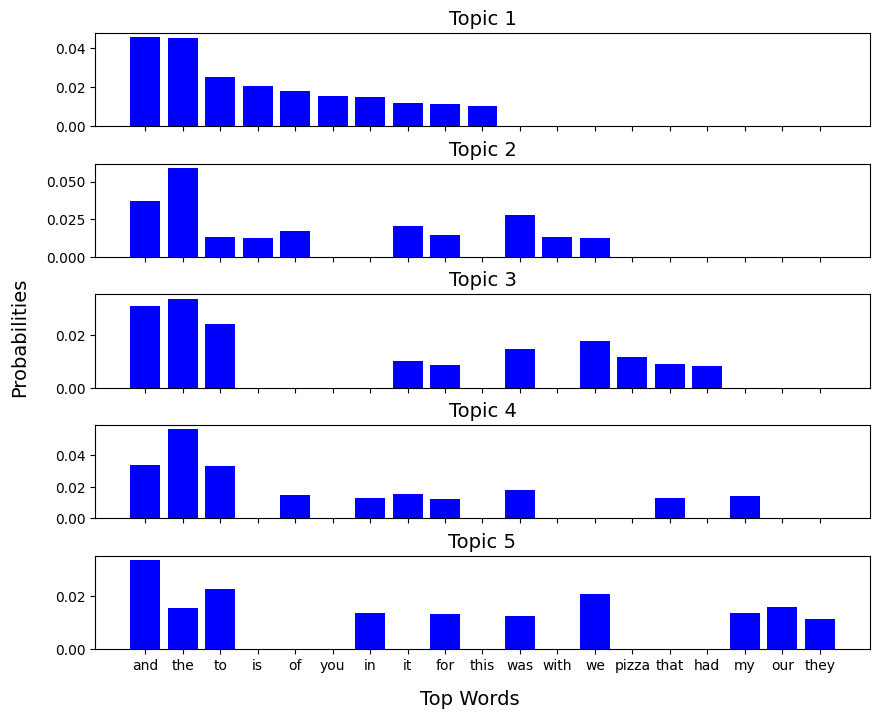

In [65]:
# Extract the top words for each topic and their corresponding probabilities
top_words = lda.show_topics(num_topics=num_topics, num_words=10, formatted=False)
word_probs = np.array([word[1] for topic in top_words for word in topic[1]])

# Create a figure with subplots for each topic
fig, axs = plt.subplots(num_topics, 1, figsize=(10, 8), sharex=True)

# Iterate over each topic and create a bar plot of the top words
for i, topic in enumerate(top_words):
    words = [word[0] for word in topic[1]]
    probs = [word[1] for word in topic[1]]
    axs[i].bar(words, probs, color='blue')
    axs[i].set_title(f'Topic {i+1}', fontsize=14)

# Set the common x and y labels
fig.text(0.5, 0.04, 'Top Words', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Probabilities', va='center', rotation='vertical', fontsize=14)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4)

visual_plot = fig

In [66]:
# Visible Testing
assert visual_plot.__module__ == 'matplotlib.axes._subplots', "You must create and assign to visual_plot a visualization"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AssertionError: ignored

In [ ]:
# Cell for matplotlib visualzation
# YOUR CODE HERE
# Extract the top words for each topic and their corresponding probabilities
top_words = lda.show_topics(num_topics=num_topics, num_words=10, formatted=False)
word_probs = np.array([word[1] for topic in top_words for word in topic[1]])

# Create a figure with subplots for each topic
visual_plot, axs = plt.subplots(num_topics, 1, figsize=(10, 8), sharex=True)

# Iterate over each topic and create a bar plot of the top words
for i, topic in enumerate(top_words):
    words = [word[0] for word in topic[1]]
    probs = [word[1] for word in topic[1]]
    axs[i].bar(words, probs, color='blue')
    axs[i].set_title(f'Topic {i+1}', fontsize=14)

# Set the common x and y labels
visual_plot.text(0.5, 0.04, 'Top Words', ha='center', fontsize=14)
visual_plot.text(0.04, 0.5, 'Probabilities', va='center', rotation='vertical', fontsize=14)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Display the plot
plt.show()
